# **Analyse de sentiments sur les films du TOP 100 box office (Notebook pour l'analyse statistique et la modélisation) 3/3**
**Projet Python - 2A ENSAE**

AUMONT Louis-Armand, KHAIRALDIN Ahmed, GIMENES Vincent

## Introduction

L'objectif de ce Notebook va être de procéder à une analyse de statistique descriptive avec nos variables et visualiser des relations entre elles
et modéliser pour tenter d'analyser les relations entre nos variables (linéaires, quadratiques), si pas de relation apparente, tester statistiquement la non-corrélation


####  Import Library 📦

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#### chargement des data

In [2]:
df = pd.read_csv("data_post_process_2o2.csv")

Nous allons exprimer la durée des films en minute pour pouvoir faire des statistiques:

In [3]:
def convert_min(duree):
    if 'h' in duree and 'm' in duree:
        # Séparation de la durée en heures et minutes
        hours, minutes = map(int, duree.replace('h', '').replace('m', '').split())
    elif 'h' in duree:
        # Si la chaîne contient "h" mais pas "m"
        hours = int(duree.split('h')[0])
        minutes = 0
    elif 'm' in duree:
        # Si la chaîne contient "m" mais pas "h"
        hours = 0
        minutes = int(duree.split('m')[0])
    else:
        # Si la chaîne ne contient ni "h" ni "m"
        hours = int(duree)
        minutes = 0
    return hours*60 + minutes
    

In [4]:
# Dans le cas où o considère la durée comme une variable quantitative
df['duree'] = df['duree'].apply(convert_min)

In [5]:
# On crée une nouvelle colonne des tokens lemmatisés
df['Tokens lemmatisés'] = df['Tokens'].apply(lemm2)
df.sample(5)

KeyError: 'Tokens'

### **1.3** Représentation des mots

Maintenant, visualisons pour certains commentaires les mots les plus représentés après nettoyage des commentaires.

Commençons d'abord par visualiser un premier nuage de mots d'un commentaire quelconque.

In [ ]:
# Fonction qui prend en argument une liste de tokens et qui retourne le nuage de mots correspondant.

def cloud(tokens):
    text = " ".join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    return wordcloud

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(cloud(df['Tokens lemmatisés'][0]), interpolation='bilinear')
plt.axis("off")
plt.show()

Par exemple, pour le premier commentaire de la bdd, on peut dès à présent avoir une idée sur son avis vis à vis du film grâce à ce nuage de mots, de par la présence de mots tels que 'masterpiece, 'magnificent', 'perfection'... qui sont assez représentés. Néanmoins, comme nous avons utilisé nltk, le lemmatiseur ne reconnait pas les entités nommés telles que 'IMAX', 'India'... .

In [ ]:
#Convertir les commentaires en string.
def string_function(column):
    return column.str.lower()

df['Commentaire'] =  string_function(df["Commentaire"])

Nous allons comparer les différents algorithmes proposés, notamment ceux des modules TextBlob, nltk et scapy.

On va dans un premier temps utiliser le module TextBlob

In [ ]:
def analyze_sentiment_blob(tokens):
    text = ' '.join(tokens)
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [ ]:
# Appliquez la fonction à la colonne 'tokens_lemmatized' du DataFrame
df['sentiment_polarity_blob'] = df['Tokens lemmatisés'].apply(analyze_sentiment_blob)

On essaye maintenant avec la fonction SentimentIntensityAnalyzer de nltk

In [ ]:
def analyze_sentiment_nltk(tokens):
    text = ' '.join(tokens)
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

In [ ]:
%%time
df['sentiment_polarity_nltk'] = df["Tokens lemmatisés"].apply(analyze_sentiment_nltk)

On essaye enfin de faire de l'analyse de sentiment avec le module scapy.

La fonction ci-dessus ne fonctionne pas bien puisqu'elle retourne que des 0. Je la laisse au cas où on trouve le problème.

Les notes et les années sont sous forme de string. Nous changeons cela pour pourvoir faire des statistiques avec.

In [ ]:
df.dtypes

In [ ]:
#change le type de la colonne 'Note imdb' en float
df['Note imdb'] = df['Note imdb'].str.replace(',', '.').astype(float)
df['Annee'] = df['Annee'].astype(float)
df["Budget"] = df["Budget"].astype(float)
df['Box office'] = df["Box office"].astype(float)

On groupe les observations selon le film.

In [ ]:
grouped = df.groupby('Film')
df_grouped = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob",  'Note imdb', 'Annee', "Budget", "Box office"]].mean()

Il peut être interessant de regarder aussi la variance des scores

In [ ]:
var_by_group = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob"]].var()

In [ ]:
correlation = df_grouped['sentiment_polarity_nltk'].corr(df_grouped['Note imdb'])
print(f"La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk est de {correlation}")

In [ ]:
correlation = df_grouped['sentiment_polarity_blob'].corr(df_grouped['Note imdb'])
print(f"La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de {correlation}")

In [ ]:
correlation = df_grouped['sentiment_polarity_nltk'].corr(df_grouped['sentiment_polarity_blob'])
print(f"La correlation entre la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de {correlation}")

Il y a une relation positive non négligeable entre les notes et le score des commentaires. Il y a également une forte corrélation entre les scores évalués par textblob et ceux évalués par nltk.

## **1.** Etude statistique du DataFrame

Nous allons séparer l'étude de notre DataFrame en deux temps:
- En premier lieu, analyse des variables numériques
- En second lieu, analyse statistique des commentaires

### **1.1** Variables numérique   
En premier lieu, on va regarder le type des variables de notre DataFrame afin de différencier les variables catégoriques, continues et textuelles

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Film                     95 non-null     object 
 1   var_score_nltk           95 non-null     float64
 2   var_score_blob           95 non-null     float64
 3   duree                    95 non-null     int64  
 4   sentiment_polarity_nltk  95 non-null     float64
 5   sentiment_polarity_blob  95 non-null     float64
 6   Note imdb                95 non-null     float64
 7   Annee                    95 non-null     float64
 8   Budget                   95 non-null     float64
 9   Box office               95 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 7.5+ KB


On va donc s'intéresser en premier lieu aux variables suivantes: Note imdb, Budget, Box Office

In [7]:
sns.set(style="darkgrid")

#### **1.1.1** Les notes

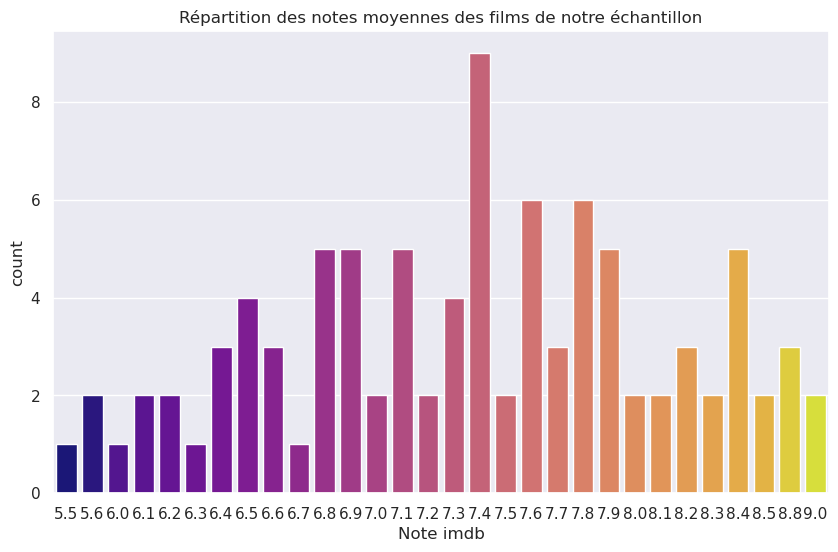

In [8]:
# Répartition de la note moyenne sur notre échantillon de 100 films
plt.figure(1, (10,6))
sns.countplot(x=df['Note imdb'], hue=df['Note imdb'], palette="plasma", legend=False)
plt.title('Répartition des notes moyennes des films de notre échantillon')
plt.show()

Les notes de notre échantillons semblent bien réparties en dans l'intervalle [5.5, 9.0], avec une forte concentration autour de 7.4, qui est la moyenne des notes de notre échantillon. 
La note minimale pour un film du top 100 sur IMDB est 5.5. La perfection ne semble pas atteignable aux yeux des spectateurs car la note maximale attribuée est de 9.0.

Nous allons maintenant nous intéresser à la distribution de ces notes.

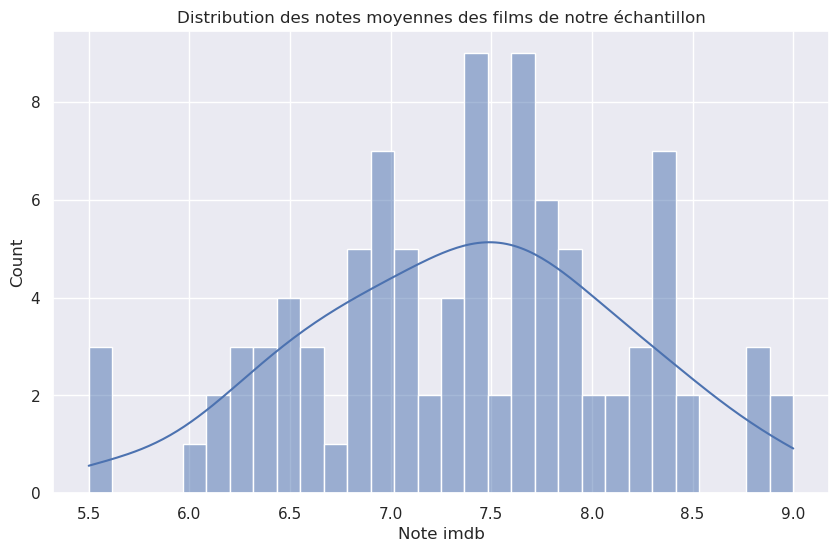

In [9]:
plt.figure(1, (10,6))
sns.histplot(x=df['Note imdb'],kde=True, bins=30)
plt.title('Distribution des notes moyennes des films de notre échantillon')
plt.show()

**test de normalité**

Nous pouvons le visualiser grace à un QQ plot:

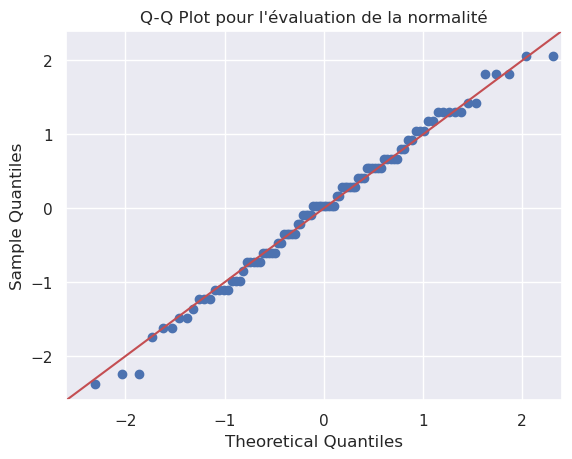

In [12]:
# Créer un Q-Q plot
sm.qqplot((df['Note imdb']-df['Note imdb'].mean())/df['Note imdb'].std(), line='45')

# Ajouter des titres et afficher le plot
plt.title("Q-Q Plot pour l'évaluation de la normalité")
plt.show()

Nous pouvons conclure que les notes suivent une loi Normale

#### **1.1.2** Budget et Box-Office

In [13]:
# Création des variables budget et box_office
budget = df['Budget']
box_office = df['Box office']

**Statistiques du budget**

In [14]:
min_budget = df.index[df['Budget'] == df['Budget'].min()][0]
max_budget = df.index[df['Budget'] == df['Budget'].max()][0]

In [15]:
# Affichage des statistiques principales
print('=== *Statistiques Budget* ===')
print(f'Le budget moyen des 100 meilleurs films sur IMDB est de {round(budget.mean()/10**6)} millions de $')
print(f'Le film du top 100 au plus faible budget est {df.loc[min_budget,"Film"]} et a un budget de {round(budget.min()/10**6)} millions de $')
print(f'Le film du top 100 au plus haut budget est {df.loc[max_budget,"Film"]} et a un budget de {round(budget.max()/10**6)} millions de $')

=== *Statistiques Budget* ===
Le budget moyen des 100 meilleurs films sur IMDB est de 175 millions de $
Le film du top 100 au plus faible budget est Le Roi Lion (1994) et a un budget de 45 millions de $
Le film du top 100 au plus haut budget est Avengers: Endgame (2019) et a un budget de 356 millions de $


**Statistiques du Box-Office**

In [16]:
min_bo = df.index[df['Box office'] == df['Box office'].min()][0]
max_bo = df.index[df['Box office'] == df['Box office'].max()][0]

In [17]:
# Affichage des statistiques principales
print('=== *Statistiques Box office* ===')
print(f'Le revenu moyen des 100 meilleurs films sur IMDB est de {round(box_office.mean()/10**6)} millions de $')
print(f'Le film du top 100 au plus faible revenu est {df.loc[min_bo,"Film"]} et a un revenu de {round(box_office.min()/10**6)} millions de $')
print(f'Le film du top 100 au plus haut revenu est {df.loc[max_bo,"Film"]} et a un revenu de {round(box_office.max()/10**6)} millions de $')

=== *Statistiques Box office* ===
Le revenu moyen des 100 meilleurs films sur IMDB est de 1151 millions de $
Le film du top 100 au plus faible revenu est Shrek le troisième (2007) et a un revenu de 813 millions de $
Le film du top 100 au plus haut revenu est Avatar (2009) et a un revenu de 2924 millions de $


**Aperçu stylisé des statistiques ci-dessus**

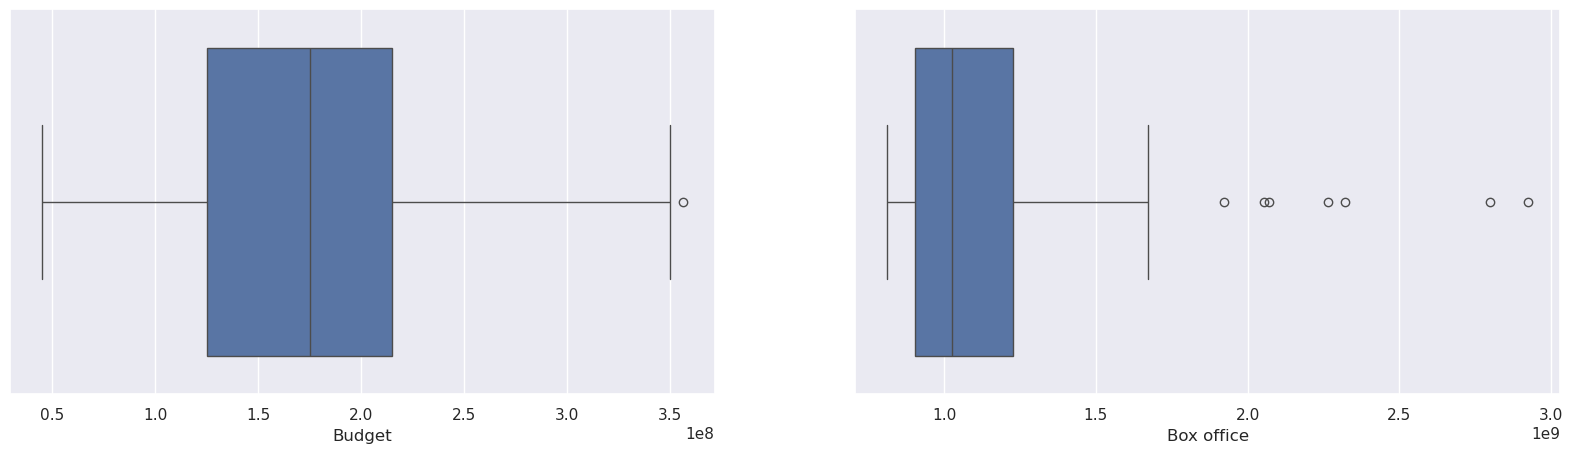

In [18]:
plt.figure(1, (20,5))

#1er boxplot
plt.subplot(1,2,1)
sns.boxplot(x=budget)

#2eme boxplot
plt.subplot(1,2,2)
sns.boxplot(x=box_office)

plt.show()

La boîte à moustache du budget nous permet de visualiser les statistiques décrites précédemment. De plus, 50% des films ont un budget compris entre 1.25 et 2.1 millons de $ avec un seul outlier.    
La boîte à moustache sur le Box-office nous montre une forte variance entre les revenus générés par les différents films avec de nombreux outliers qui ont des revenus buine plus élevés que la moyenne. 

**visualisation des distributions**

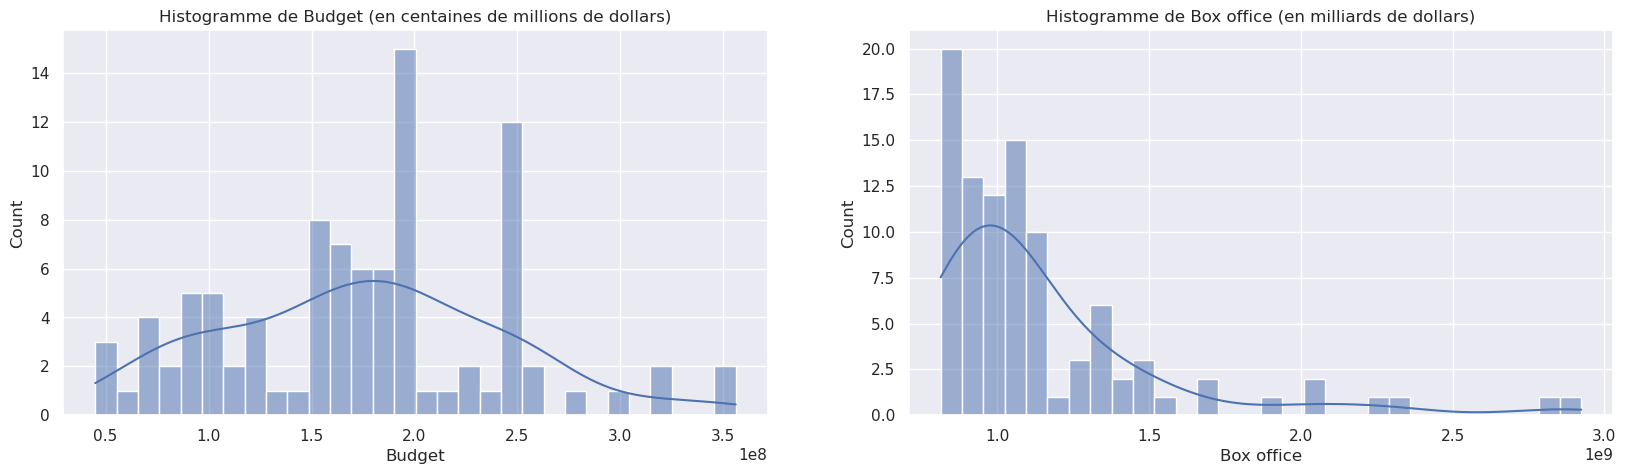

In [19]:
plt.figure(2, (20,5))

#1er histogramme
plt.subplot(1,2,1)
sns.histplot(x=budget ,kde=True, bins=30)
plt.title('Histogramme de Budget (en centaines de millions de dollars)')

#2eme histogramme
plt.subplot(1,2,2)
sns.histplot(x=box_office, kde=True, bins=30)
plt.title('Histogramme de Box office (en milliards de dollars)')
plt.show()

**log box-office**

La distribution du budget est un peu près normale. Mais la distribution du box office a un "fat tail" et a un gros "skiew".

En général, les variables de revenus suivent des lois des Paretos ou log-normale. Il semble au vu du box plot et du l'histogramme que cela soit également le cas pour notre variable box_office qui est aussi en quelque sorte un revenu. Nous allons donc créer une nouvelle variable log_box_office qui est le log du Box office, puis l'analyser:

In [20]:
df['log_Box_office'] = np.log(df['Box office'])

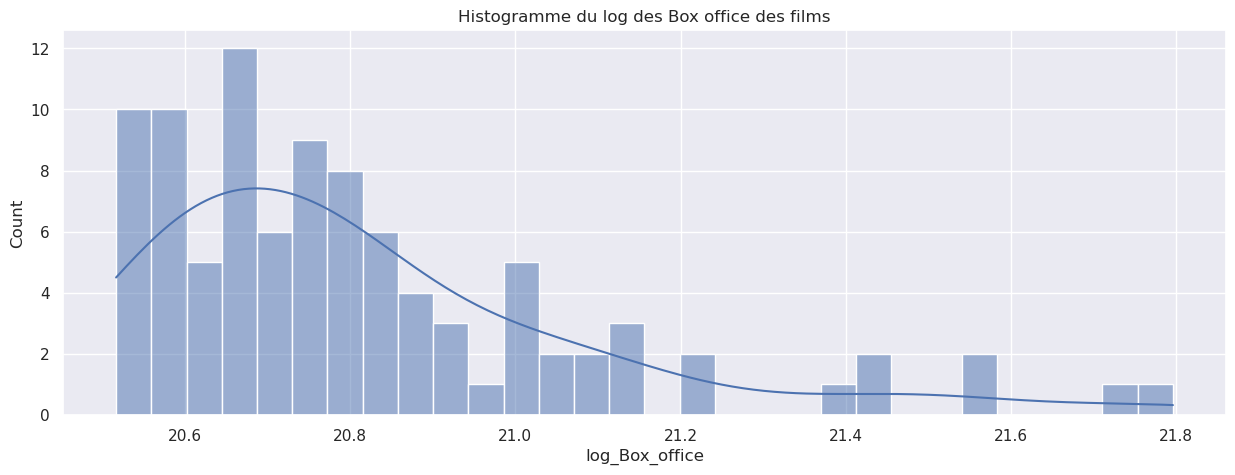

In [21]:
plt.figure(1, (15,5))
sns.histplot(x=df['log_Box_office'], kde=True, bins=30)
plt.title("Histogramme du log des Box office des films")
plt.show()

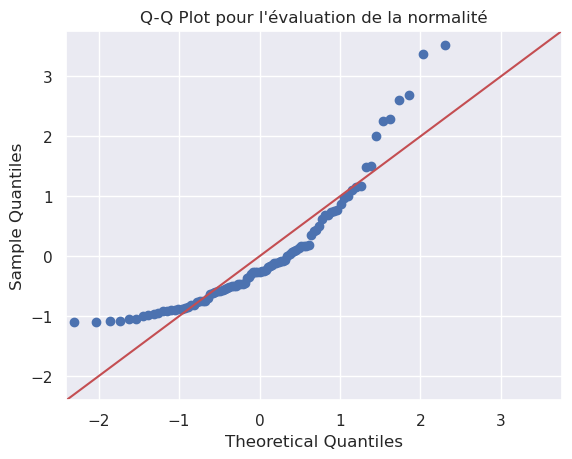

In [22]:
# Créer un Q-Q plot
sm.qqplot((df['log_Box_office']-df['log_Box_office'].mean())/df['log_Box_office'].std(), line='45')

# Ajouter des titres et afficher le plot
plt.title("Q-Q Plot pour l'évaluation de la normalité")
plt.show()

Le Log-Box-Office ne suit pas vraiment un loi normale au vu du QQ plot bien que la courbe semble s'en être rapproché au vu de l'histogramme

#### **1.1.3** La durée des films

In [25]:
#statistiques descriptives
print('=== *Statistiques sur la Duree* ===')
print(df['duree'].describe())

=== *Statistiques sur la Duree* ===
count     95.000000
mean     134.515789
std       25.943008
min       87.000000
25%      118.000000
50%      136.000000
75%      149.500000
max      201.000000
Name: duree, dtype: float64


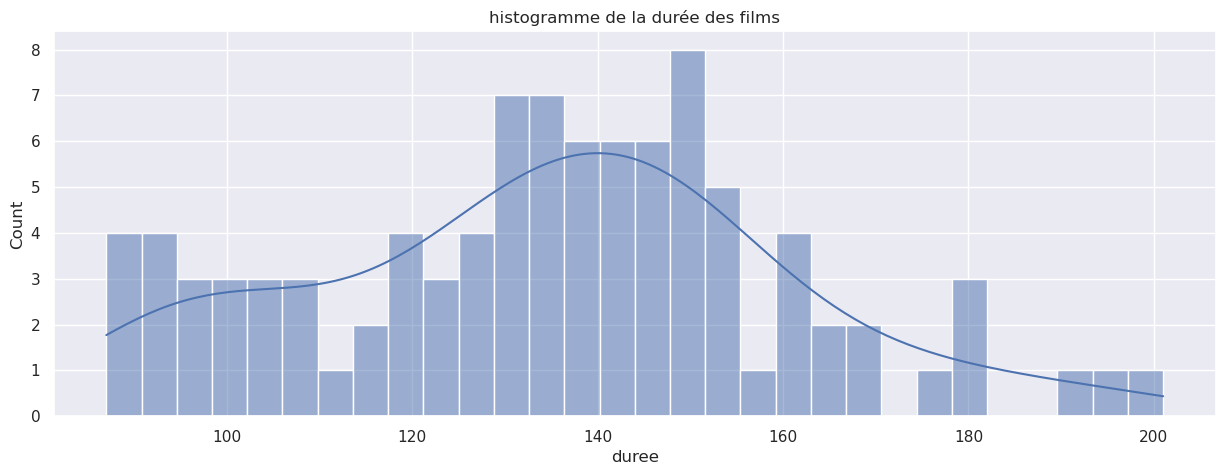

In [26]:
plt.figure(1, (15,5))
sns.histplot(x=df['duree'], kde=True, bins=30)
plt.title("histogramme de la durée des films")
plt.show()

Il semble y avoir 3 types assez distincts: 
+ Les films courts avec une durée inférieure à 2H
+ Les films standards d'une durée de 2H jusqu'à 2H30
+ et enfin les films longs, moins nombreux, d'une durée supérieur à 2H30

### **1.2** Variables textuelles   
Après l'étude statistique des variables numériques, nous allons maintenant analyser les commentaires d'un point de vue statistique

In [27]:
df.head()

,Film,var_score_nltk,var_score_blob,duree,sentiment_polarity_nltk,sentiment_polarity_blob,Note imdb,Annee,Budget,Box office,log_Box_office
0,007 Spectre (2015),0.468121,0.028772,148,0.545586,0.130661,6.8,2015.0,245000000.0,8.807053e+08,20.596234
1,Aladdin (2019),0.285684,0.055514,128,0.624164,0.175002,6.9,2019.0,183000000.0,1.054304e+09,20.776147
2,Alice au pays des merveilles (2010),0.295968,0.027473,108,0.723677,0.137034,6.4,2010.0,200000000.0,1.025468e+09,20.748415
3,Aquaman (2018),0.504025,0.092883,143,0.276618,0.006167,6.8,2018.0,160000000.0,1.157347e+09,20.869397
4,Avatar (2009),0.155810,0.022904,162,0.844516,0.213078,7.9,2009.0,237000000.0,2.923706e+09,21.796118


#### **1.2.1** Autour de la distribution des scores de polarité moyens

**Distribution de la polarité moyenne des sentiments par film:**
+ **Avec Text Blob**

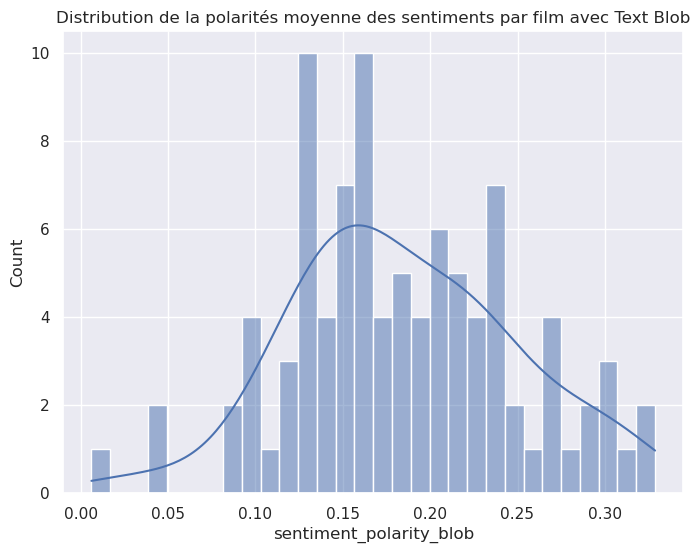

In [28]:
# Affichage de l'histogramme 
plt.figure(1, (8,6))
sns.histplot(df['sentiment_polarity_blob'],kde=True, bins=30)
plt.title('Distribution de la polarités moyenne des sentiments par film avec Text Blob')
plt.show()

* **Avec NLTK**

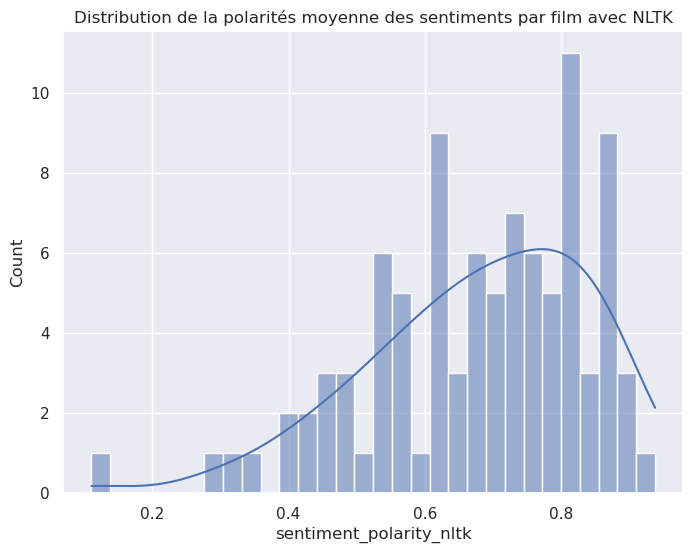

In [29]:
# Affichage de l'histogramme 
plt.figure(1, (8,6))
sns.histplot(df['sentiment_polarity_nltk'],kde=True, bins=30)
plt.title('Distribution de la polarités moyenne des sentiments par film avec NLTK')
plt.show()

En comparant les deux histogrammes on remarque que les distributions sont bien différentes selon le modèle de NLP utilisé. En effet, la distribution des polarité avec Text_blob a une très faible variance et est très concentrée entre 0.10 et 0.25. En revanche, les polarités avec NLTK semble être normalement distribuée avec une présence de skewness pronnoncée. 

Après investigation, il semblerait que Text Blob soit construit sur NLTK et spécialisé dans l'analyse des sentiments. De plus, au vu des histogrammes, la distribution de la variable évaluée avec Text Blob se rapproche plus d'une normale. Ce qui est préférable pour vérifier certaines hypothèses. Nous allons donc garder uniquement les variables évaluées avec Text Blob:

Elles sont de toute façon très corrélées:

In [33]:
print(df['sentiment_polarity_nltk'].corr(df['sentiment_polarity_blob']))

0.7417632126035838


In [34]:
#Supprime les colonne 'sentiment_polarity_nltk' et 'var_score_nltk'
df = df.drop(['sentiment_polarity_nltk','var_score_nltk'], axis=1)

#### **1.2.2** Distribution de la variance des scores des sentiments

Nous rappelons que la variable "sentiment_polarity_blob" a été évalué en i) attribuant un score de polarité à chaque commentaire de notre dataset ii) faisant la moyenne de ces scores pour chaque film. <br> 
La variable "var_score_blob" quant à elle, a été évaluée en prenant la variance des scores de polarité pour chaque film. Cela nous permet d'évaluer le "clivage" d'un film. C'est-à-dire évaluer si tout le monde avait un peu près le même avis, le même score de polarité, ou alors s'il avait des gens avec un score très favorable et d'autres avec un score très défavorable. En effet, cela n'est pas capté par notre varaible sentiment polarity puisqu'il s'agit d'une moyenne.

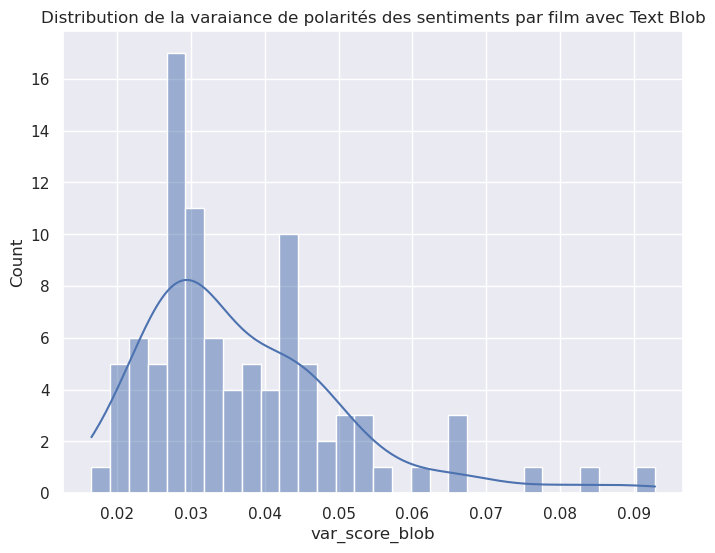

In [39]:
# Affichage de l'histogramme 
plt.figure(1, (8,6))
sns.histplot(df['var_score_blob'],kde=True, bins=30)
plt.title('Distribution de la varaiance de polarités des sentiments par film avec Text Blob')
plt.show()

On observe que la plupart des films ont un peu près une faible variance des scores. Il y a cependant des films avec de grosses disparités dans les scores (4-5 films avec une variance des scores supérieure à 0.06)

### **1.3** Interactions entre les variables

Nous allons désormais étudier en bref l'interaction qu'ont nos variables entre elles, en nous concentrant surtout sur nos variables de score de polarité:

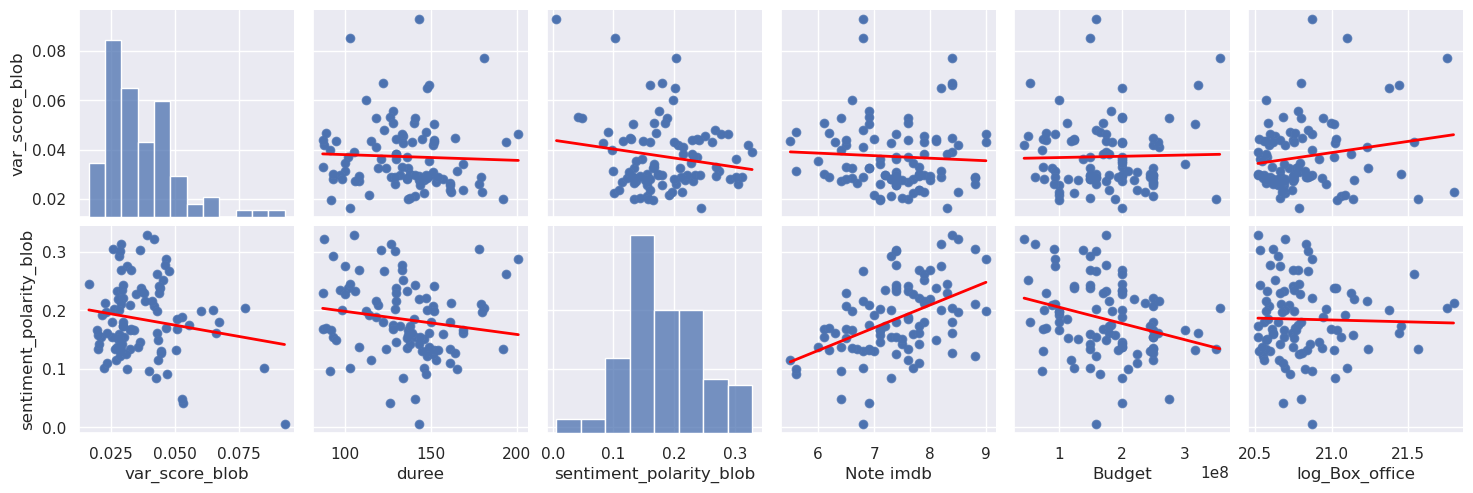

In [51]:
#variables sur les lignes du pairplot
y_vars = ['var_score_blob', 'sentiment_polarity_blob']

#initialise le pair plot
g = sns.pairplot(df.drop(['Annee', 'Box office'], axis = 1), y_vars=y_vars)
# Ajoute des scatter plots sur la diagonale
g.map_diag(sns.scatterplot)
# Ajoute des scatter plots et des lignes de régression en dehors de la diagonale
g.map_offdiag(sns.regplot, line_kws={'color': 'red', 'linewidth': 2}, ci=None)
# Affiche le graphique
plt.show()

Ce graphique est assez lourd à interpréter.<br>
Tout d'abord concentrons nous sur la variable sentiment_polarity_blob:
+ Elle semble être légérement corrélée négativement avec les variables "var_score_blob", "duree" et "budget"
+ indépendante du log du box office
+ corrélée positivement avec la variable de la note du film

Quant à la variable var_score_blob:
+ Elle semble être indépendante de la duree, de la note et du budget
+ légérement corrélée négativement avec la variable sentiment_polarity
+ légérement corrélée positivement avec la variable log_box_office

## **2.** Etude Econometrique

Nous allons maintenant pouvoir tenter de répondre à certaines questions via une analyse économétrique en prenant compte la partie précédente.

### 2.1 Les scores calculés par l'algorithme d'imdb reste-t-il cohérent avec la note des films ?

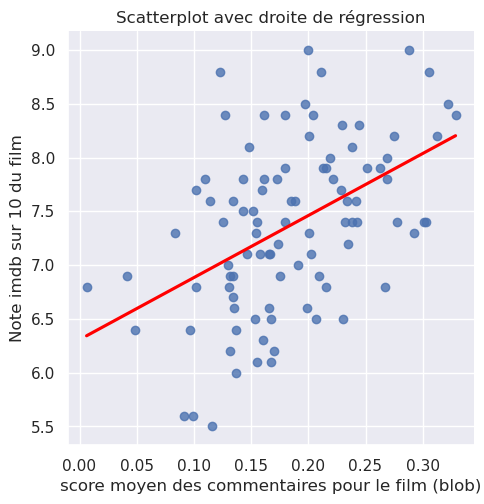

In [62]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_blob', y='Note imdb', data=df, line_kws={'color': 'red'}, ci=None)
# Ajout de titres et de labels
plt.title('Scatterplot avec droite de régression')
plt.xlabel('score moyen des commentaires pour le film (blob)')
plt.ylabel('Note imdb sur 10 du film')

# Affichage du graphique
plt.show()

Le graphique nous montre que les scores semblement bien "fiter" avec les notes.

In [59]:
#ajout de la constante
df = sm.add_constant(df)

In [63]:
# régression de la note note imdb sur le score "sentiment_polarity_blob"
model_1 = sm.OLS(df['Note imdb'], df[['const', 'sentiment_polarity_blob']]).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:              Note imdb   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     26.86
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           1.27e-06
Time:                        15:13:42   Log-Likelihood:                -99.664
No. Observations:                  95   AIC:                             203.3
Df Residuals:                      93   BIC:                             208.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Le coefficient estimé de la variable "sentiment_polarity_blob" est bien sûr ininterprétable (à part qu'il est positif) puisque l'échelle est arbitraire. Cependant, nous pouvons remarquer que le $R^{2}$ est de 0.2. Ce qui signifie que les scores de polarité explique tout de même 20% de la variance des notes. Le coefficient estimé a une p-value proche de zero. Ce qui signifie que les notes et les scores ont une corrélation statistiquement significative.

La réponse a notre question est donc oui.

### **2.2** Est-ce que plus un film est long, plus les commentaires seront négatifs ?